In [133]:
#!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import datetime as dt

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [22]:
# actuals_pre = pd.read_csv('ElectricityForecaster/Train/Actual_Pre.csv')
# actuals_post = pd.read_csv('ElectricityForecaster/Train/Actual_Post.csv')
# actuals2 = pd.concat([actuals_pre, actuals_post], ignore_index=True)

In [3]:
actuals = pd.read_csv('ElectricityForecaster/Train/Compiled.csv')

In [13]:
#renaming the columns
actuals = actuals.rename(columns = {'humid':'humidity', 'wind_dir':'wind_direction','wind_sp':'wind_speed_kmh',
                            'pressure_f':'pressure_kpa', 'cloud_cov':'cloud_cover', 'temp':'temperature_c',
                            ' year':'year'})

In [6]:
actuals.head()

,index,load,pressure,cloud_cover,humidity,temperature_c,wind_direction,wind_speed_kmh,pressure_kpa,cloud_cov_f,...,h20,h21,h22,h23,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos
0,0,1031471.62800,1012.48000,2.12500,79.33333,16.76439,285.25000,6.25375,1011.00000,3.00000,...,0,0,0,0,0.00000,1.00000,1.00000,0.00000,-0.48530,-0.87435
1,1,1007205.57800,1011.61875,0.00000,82.16667,15.72939,285.00000,9.20500,1011.00000,4.00000,...,0,0,0,0,0.25882,0.96593,1.00000,0.00000,-0.48530,-0.87435
2,2,986108.40070,1010.72000,2.12500,81.66667,15.81689,316.00000,11.28375,1011.00000,4.00000,...,0,0,0,0,0.50000,0.86603,1.00000,0.00000,-0.48530,-0.87435
3,3,970760.96690,1011.37625,17.12500,82.25000,15.91939,327.00000,7.16875,1011.00000,4.00000,...,0,0,0,0,0.70711,0.70711,1.00000,0.00000,-0.48530,-0.87435
4,4,962258.36500,1011.50000,18.62500,82.33333,15.76939,282.25000,0.78000,1011.00000,4.00000,...,0,0,0,0,0.86603,0.50000,1.00000,0.00000,-0.48530,-0.87435


In [24]:
# actuals2['time'] = pd.to_datetime(actuals2['time'], dayfirst = True)
# actuals2['time'] = pd.to_str(actuals['time'], format = '%Y-%m-%d %H:%M:%S')

### Autocorrelation 

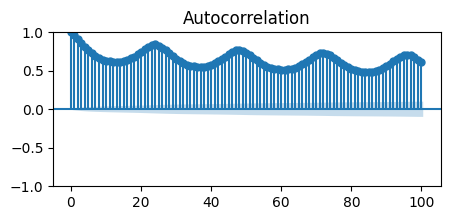

In [4]:
fig, ax = plt.subplots(figsize=(5,2))
plot_acf(actuals.humidity, ax=ax, lags=100)
plt.show()

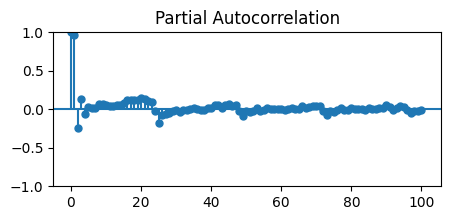

In [5]:
fig, ax = plt.subplots(figsize=(5,2))
plot_pacf(actuals.humidity, ax=ax, lags=100)
plt.show()

It's just a little bit of autocorrelation saurrr

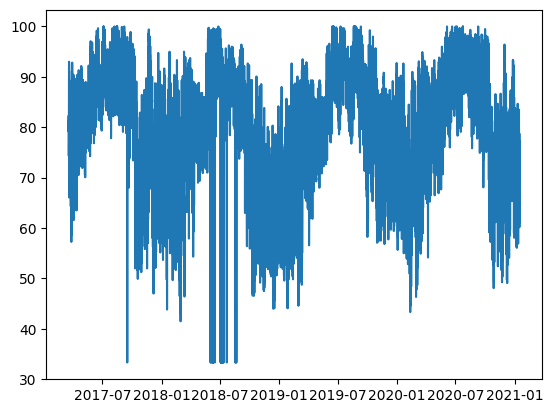

In [25]:
plt.plot(actuals2["time"], actuals2['humidity'])

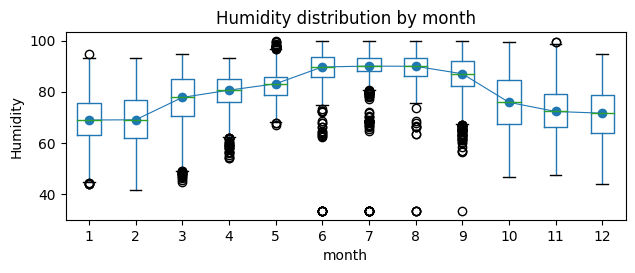

In [8]:
fig, ax = plt.subplots(figsize=(7, 2.5))
actuals.boxplot(column='humidity', by='month', ax=ax,)
actuals.groupby('month')['humidity'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Humidity')
ax.set_title('Humidity distribution by month')
fig.suptitle('');

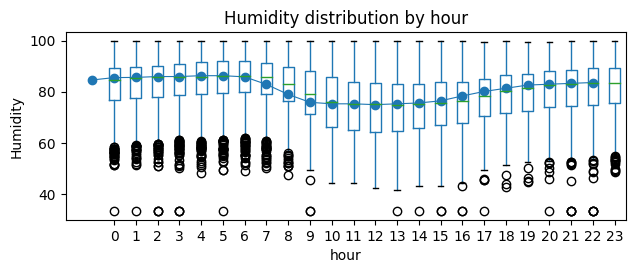

In [7]:
fig, ax = plt.subplots(figsize=(7, 2.5))
actuals.boxplot(column='humidity', by='hour', ax=ax,)
actuals.groupby('hour')['humidity'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Humidity')
ax.set_title('Humidity distribution by hour')
fig.suptitle('');

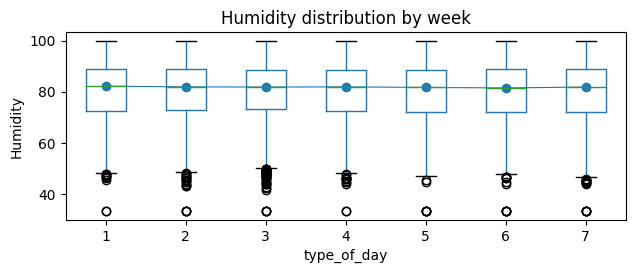

In [10]:
fig, ax = plt.subplots(figsize=(7, 2.5))
actuals.boxplot(column='humidity', by='type_of_day', ax=ax,)
actuals.groupby('type_of_day')['humidity'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Humidity')
ax.set_title('Humidity distribution by week')
fig.suptitle('');

### Cyclic Encoding (ignore this!!)

In [12]:
temp_actuals = actuals

In [42]:
temp_actuals['time'] = pd.to_datetime(temp_actuals['time'], dayfirst = True)

In [43]:
temp_actuals['temphour'] = temp_actuals.time.dt.hour

In [44]:
temp_actuals['tempmonth'] = temp_actuals.time.dt.month

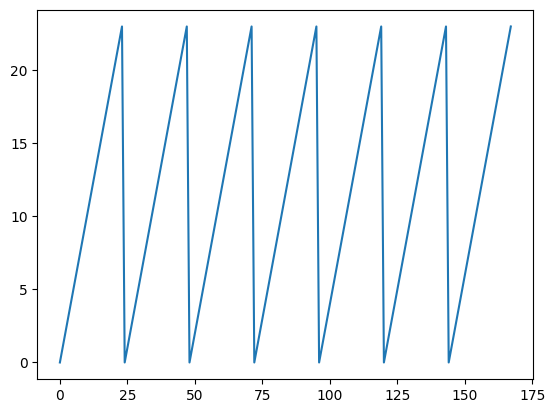

In [45]:
sample = temp_actuals[:168]
ax = sample['temphour'].plot()

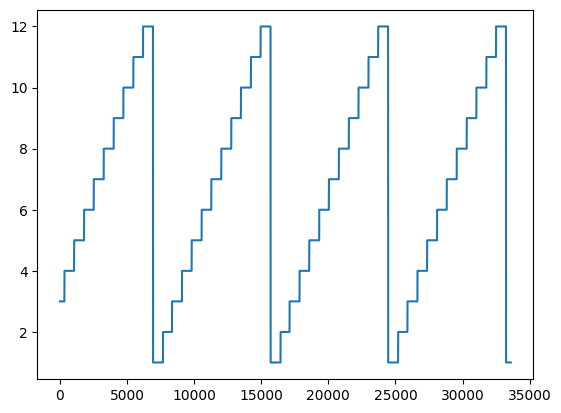

In [46]:
ax = temp_actuals['tempmonth'].plot()

In [49]:
#converting for hourly data
temp_actuals['hour_sin'] = np.sin(2*np.pi * temp_actuals['temphour']/24)

temp_actuals['hour_cos'] = np.cos(2*np.pi * temp_actuals['temphour']/24)

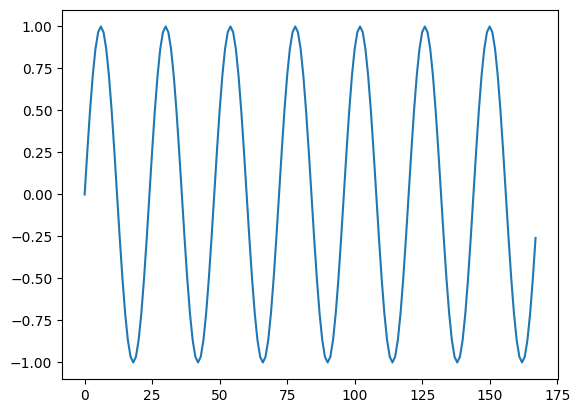

In [51]:
sample = temp_actuals[:168]
ax = sample['hour_sin'].plot()

In [54]:
temp_actuals['month_sin'] = np.sin(2*np.pi * temp_actuals['tempmonth']/12)
temp_actuals['month_cos'] = np.cos(2*np.pi * temp_actuals['tempmonth']/12)

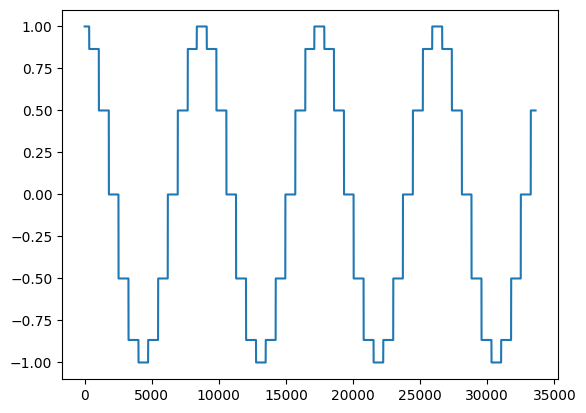

In [57]:
ax = temp_actuals['month_sin'].plot()

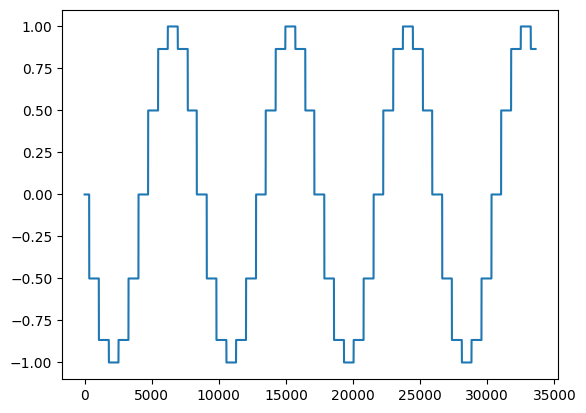

In [59]:
ax = temp_actuals['month_cos'].plot()

### Start of Predictions

split into train and test 70:30

In [126]:
weather_x = actuals[['hour_cos', 'hour_sin', 'month_cos', 'month_sin', 'cloud_cover', 
                'temperature_c', 'wind_direction', 'wind_speed_kmh', 'pressure_kpa']]

weather_y = actuals['humidity']

In [127]:
##data is randomly split
train_x, test_x, train_y, test_y = train_test_split(
        weather_x, weather_y, test_size = 0.3, random_state=42
)

In [67]:
#ignore!! this is without cyclic encoding
# weather_x = actuals[['hour', 'month', 'cloud_cover', 'temperature_c',
#                     'wind_direction', 'wind_speed_kmh', 'pressure_kpa']]

# weather_y = actuals["humidity"]

In [37]:
##dates are in order during the splits
# train_xo = weather_x[:int((len(weather_x)+1)*.70)] 
# test_xo = weather_x[int(len(weather_x)*.70+1):] 

# train_yo = weather_y[:int((len(weather_y)+1)*.70)] 
# test_yo = weather_y[int(len(weather_y)*.70+1):] 

### Linear Regression

In [7]:
lm = linear_model.LinearRegression()

In [8]:
lm.fit(train_x.values, train_y)

LinearRegression()

In [9]:
lm_predicted=lm.predict(test_x.values)

In [10]:
mse = mean_squared_error(test_y, lm_predicted)

errors = abs(lm_predicted - test_y)
mae = round(np.mean(errors), 2)

#mape
mape = 100 * (errors/test_y)
accuracy = 100 - np.mean(mape)

In [11]:
print('Mean Squared Error for Linear Regression is: {}'.format(round(mse, 5)))
print('Mean Absolute Error for Linear Regression is: {} degrees'.format(mae))
print('Accuracy for Linear Regression is: {}%'.format(round(accuracy, 2)))


Mean Squared Error for Linear Regression is: 37.01512
Mean Absolute Error for Linear Regression is: 4.54 degrees
Accuracy for Linear Regression is: 93.81%


### Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
rf = RandomForestRegressor(n_estimators=100, random_state=64)

In [14]:
rf.fit(train_x.values, train_y)

RandomForestRegressor(random_state=64)

In [15]:
rf_predicted = rf.predict(test_x.values)

In [16]:
#mse
mse = mean_squared_error(test_y, rf_predicted)

#mae
errors = abs(rf_predicted - test_y)
mae = round(np.mean(errors), 2)

#mape
mape = 100 * (errors/test_y)
accuracy = 100 - np.mean(mape)


In [17]:
print('Mean Squared Error for Random Forest is: {}'.format(round(mse, 5)))
print('Mean Absolute Error for Random Forest is: {} degrees'.format(mae))
print('Accuracy for Random Forest is: {}%'.format(round(accuracy, 2)))

Mean Squared Error for Random Forest is: 22.31908
Mean Absolute Error for Random Forest is: 3.26 degrees
Accuracy for Random Forest is: 95.55%


### XGBoost :O

In [27]:
import xgboost as xgb
from xgboost import XGBRegressor

In [19]:
#store into DMatrix objects
train_reg = xgb.DMatrix(train_x, label=train_y)
test_reg = xgb.DMatrix(test_x, test_y)

In [20]:
#setting hyperparameter
params = {"objective": "reg:squarederror", "tree_method": "hist"}

In [26]:
n = 100  #ideal rounds is found through hyperparameter tuning
xgboost = xgb.train(
    params = params,
    dtrain=train_reg,
    num_boost_round = n
)

In [22]:
#make prediction
xgb_predicted = xgboost.predict(test_reg)

In [23]:
mse = mean_squared_error(test_y, xgb_predicted)

#mae
errors = abs(xgb_predicted - test_y)
mae = round(np.mean(errors), 2)

#mape
mape = 100 * (errors/test_y)
accuracy = 100 - np.mean(mape)

In [24]:
print('Mean Squared Error for XGBoost is: {}'.format(round(mse, 5)))
print('Mean Absolute Error for XGBoost is: {} degrees'.format(mae))
print('Accuracy for XGBoost is: {}%'.format(round(accuracy, 2)))

Mean Squared Error for XGBoost is: 24.48082
Mean Absolute Error for XGBoost is: 3.46 degrees
Accuracy for XGBoost is: 95.28%


In [164]:
params = {'objective': 'reg:squarederror', 'tree_method':'hist', 'learning_rate':0.1, 'max_depth':7, 'alpha':10}

In [169]:
#cv for xgboost for hyperparameter tuning (n)
n = 100

#tbvh idk how this is working :-)
results = xgb.cv(
    params, train_reg,
    num_boost_round=n,
    nfold=8,
    early_stopping_rounds=20
)


In [170]:
results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,72.18965,0.02820,72.19175,0.20562
1,65.03388,0.02546,65.03605,0.19590
2,58.59685,0.02308,58.60149,0.18601
3,52.80688,0.02073,52.81298,0.17951
4,47.59990,0.01807,47.60835,0.17185


In [171]:
#
best_mse = results['test-rmse-mean'].min() ** 2
best_mse

23.861699369174705

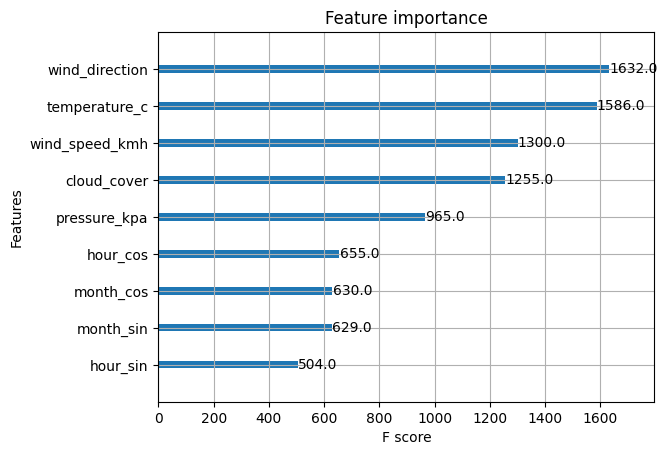

<Figure size 1600x1200 with 0 Axes>

In [172]:
#feature importance
xgb.plot_importance(xgboost)
plt.figure(figsize = (16,12))
plt.show()

#temp and wind direction has the highest feature importance for humidity

### trying XGBoost with categorical variables since it can handle them

In [131]:
xgb_x = actuals[['cloud_cover', 'temperature_c', 'wind_direction', 
                'wind_speed_kmh', 'pressure_kpa', 'month', 'hour']]

xgb_y = actuals['humidity']

In [132]:
xgb_x['month'] = pd.Categorical(xgb_x.month)
xgb_x['hour'] = pd.Categorical(xgb_x.hour)

C:\Users\danie\AppData\Local\Temp\ipykernel_17816\3987691783.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgb_x['month'] = pd.Categorical(xgb_x.month)
C:\Users\danie\AppData\Local\Temp\ipykernel_17816\3987691783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgb_x['hour'] = pd.Categorical(xgb_x.hour)


In [133]:
xgb_x.dtypes

cloud_cover        float64
temperature_c      float64
wind_direction     float64
wind_speed_kmh     float64
pressure_kpa       float64
month             category
hour              category
dtype: object

In [134]:
#split data
xgb_train_x, xgb_test_x, xgb_train_y, xgb_test_y = train_test_split(
        xgb_x, xgb_y, test_size = 0.3, random_state=42
)

In [173]:
#store into DMatrix objects
train_reg_c = xgb.DMatrix(xgb_train_x, label=xgb_train_y, enable_categorical=True)
test_reg_c = xgb.DMatrix(xgb_test_x, xgb_test_y, enable_categorical=True)
#setting hyperparameter
# params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 100  #ideal rounds is found through hyperparameter tuning
xgboost = xgb.train(
    params = params,
    dtrain=train_reg_c,
    num_boost_round = n
)
#make prediction
xgb_predicted_c = xgboost.predict(test_reg_c)
mse = mean_squared_error(xgb_test_y, xgb_predicted_c)

#mae
errors = abs(xgb_predicted_c - xgb_test_y)
mae = round(np.mean(errors), 2)

#mape
mape = 100 * (errors/xgb_test_y)
accuracy = 100 - np.mean(mape)
print('Mean Squared Error for XGBoost is: {}'.format(round(mse, 5)))
print('Mean Absolute Error for XGBoost is: {} degrees'.format(mae))
print('Accuracy for XGBoost is: {}%'.format(round(accuracy, 2)))

Mean Squared Error for XGBoost is: 24.135
Mean Absolute Error for XGBoost is: 3.43 degrees
Accuracy for XGBoost is: 95.32%


using categorical performs slightly different from using sin and cosine for month and hour

### Exponential Smoothing (Holt's Winters Seasonal)


genuinely do not understand but i will look at it again ;-;
https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

If the magnitude of the seasonal component changes with time, then the series is multiplicative. Otherwise, the series is additive.

In [51]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [26]:
#reading these files bc I need time and humidity only
actuals_pre = pd.read_csv('ElectricityForecaster/Train/Actual_Pre.csv')
actuals_post = pd.read_csv('ElectricityForecaster/Train/Actual_Post.csv')
actuals_es = pd.concat([actuals_pre, actuals_post], ignore_index=True)

actuals_es['time'] = pd.to_datetime(actuals_es['time'], dayfirst = True)


In [55]:
actuals_es.shape

(33600, 16)

In [54]:
actuals_es['time'].max()

Timestamp('2021-01-15 23:00:00')

In [56]:
index = pd.date_range(start=actuals_es['time'].min(), end=actuals_es['time'].max(), freq='1H')

In [62]:
#checking that index is correct
print(index)
print("length of index: "+ str(len(index)))

DatetimeIndex(['2017-03-18 00:00:00', '2017-03-18 01:00:00',
               '2017-03-18 02:00:00', '2017-03-18 03:00:00',
               '2017-03-18 04:00:00', '2017-03-18 05:00:00',
               '2017-03-18 06:00:00', '2017-03-18 07:00:00',
               '2017-03-18 08:00:00', '2017-03-18 09:00:00',
               ...
               '2021-01-15 14:00:00', '2021-01-15 15:00:00',
               '2021-01-15 16:00:00', '2021-01-15 17:00:00',
               '2021-01-15 18:00:00', '2021-01-15 19:00:00',
               '2021-01-15 20:00:00', '2021-01-15 21:00:00',
               '2021-01-15 22:00:00', '2021-01-15 23:00:00'],
              dtype='datetime64[ns]', length=33600, freq='H')
length of index: 33600


In [93]:
data_es = pd.Series(list(actuals_es['humidity']), index)

In [96]:
data_es

2017-03-18 00:00:00   79.33333
2017-03-18 01:00:00   82.16667
2017-03-18 02:00:00   81.66667
2017-03-18 03:00:00   82.25000
2017-03-18 04:00:00   82.33333
                        ...   
2021-01-15 19:00:00   68.33333
2021-01-15 20:00:00   73.91667
2021-01-15 21:00:00   75.83333
2021-01-15 22:00:00   74.25000
2021-01-15 23:00:00   77.25000
Freq: H, Length: 33600, dtype: float64

In [97]:
# train_es, test_es = train_test_split(
#         data_es, test_size = 0.3, random_state=42
# )

train_es = data_es[:int((len(data_es)+1)*.70)] 
test_es= data_es[int(len(data_es)*.70+1):]  

In [101]:
fit1 = ExponentialSmoothing(
    train_es,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated"
).fit()
fit2 = ExponentialSmoothing(
    train_es,
    seasonal_periods=4,
    trend="add",  #additive trend
    seasonal="mul",  #multiplicative trend
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit3 = ExponentialSmoothing(
    train_es,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit4 = ExponentialSmoothing(
    train_es,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()


c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


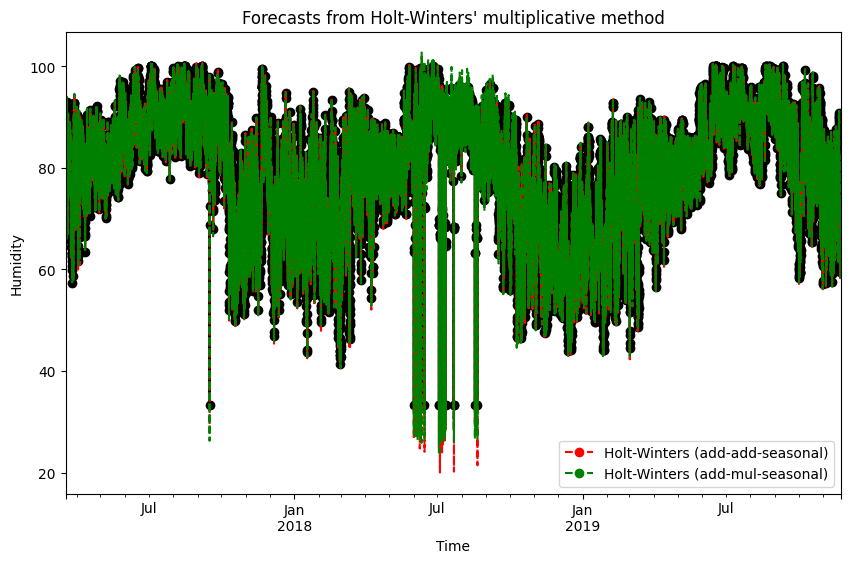

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.99500,0.99500,0.99500,0.99500
$\beta$,0.03554,0.03554,0.00010,0.00010
$\phi$,NaN,NaN,0.99000,0.99000
$\gamma$,0.00500,0.00250,0.00500,0.00250
$l_0$,91368.51425,91368.51425,91368.51425,91368.51425
$b_0$,-2234.84467,-2234.84467,-2234.84467,-2234.84467
SSE,278165.28827,287614.88192,258650.11525,261275.13181


In [107]:
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = train_es.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)
ax.set_ylabel("Humidity")
ax.set_xlabel("Time")
fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()

results

### SARIMA (ignore!! not done yet i'm still trying to figure it out)

In [121]:
#!pip install pmdarima
#!pip install itertools
import pmdarima as pm
import statsmodels.api as sm
import itertools

In [109]:
actuals_pre = pd.read_csv('ElectricityForecaster/Train/Actual_Pre.csv')
actuals_post = pd.read_csv('ElectricityForecaster/Train/Actual_Post.csv')
actuals_time = pd.concat([actuals_pre, actuals_post], ignore_index=True)

actuals_time['time'] = pd.to_datetime(actuals_time['time'], dayfirst = True)

In [111]:
data_sar = actuals_time[['time', 'cloud_cover', 'temperature_c', 'wind_direction', 
                    'wind_speed_kmh', 'pressure_kpa', 'humidity']]

In [112]:
data_sar = data_sar.set_index('time')

##### Plots

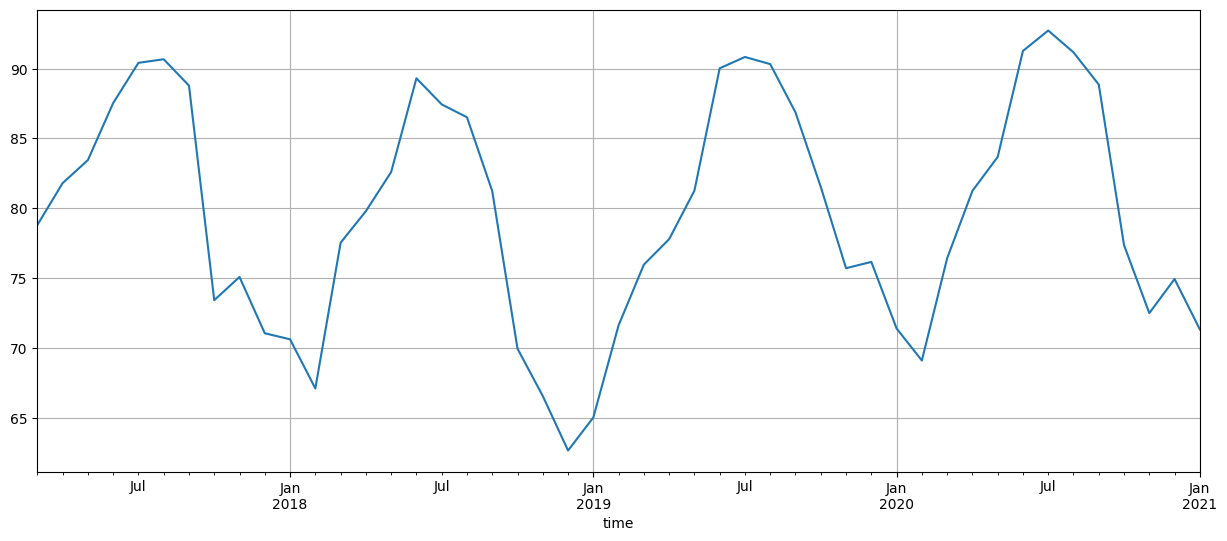

In [114]:
#aggregate the data from daily to monthly
data_sar_month = data_sar['humidity'].resample('MS').mean()
data_sar_month.plot(figsize=(15,6))
plt.grid()
plt.show()

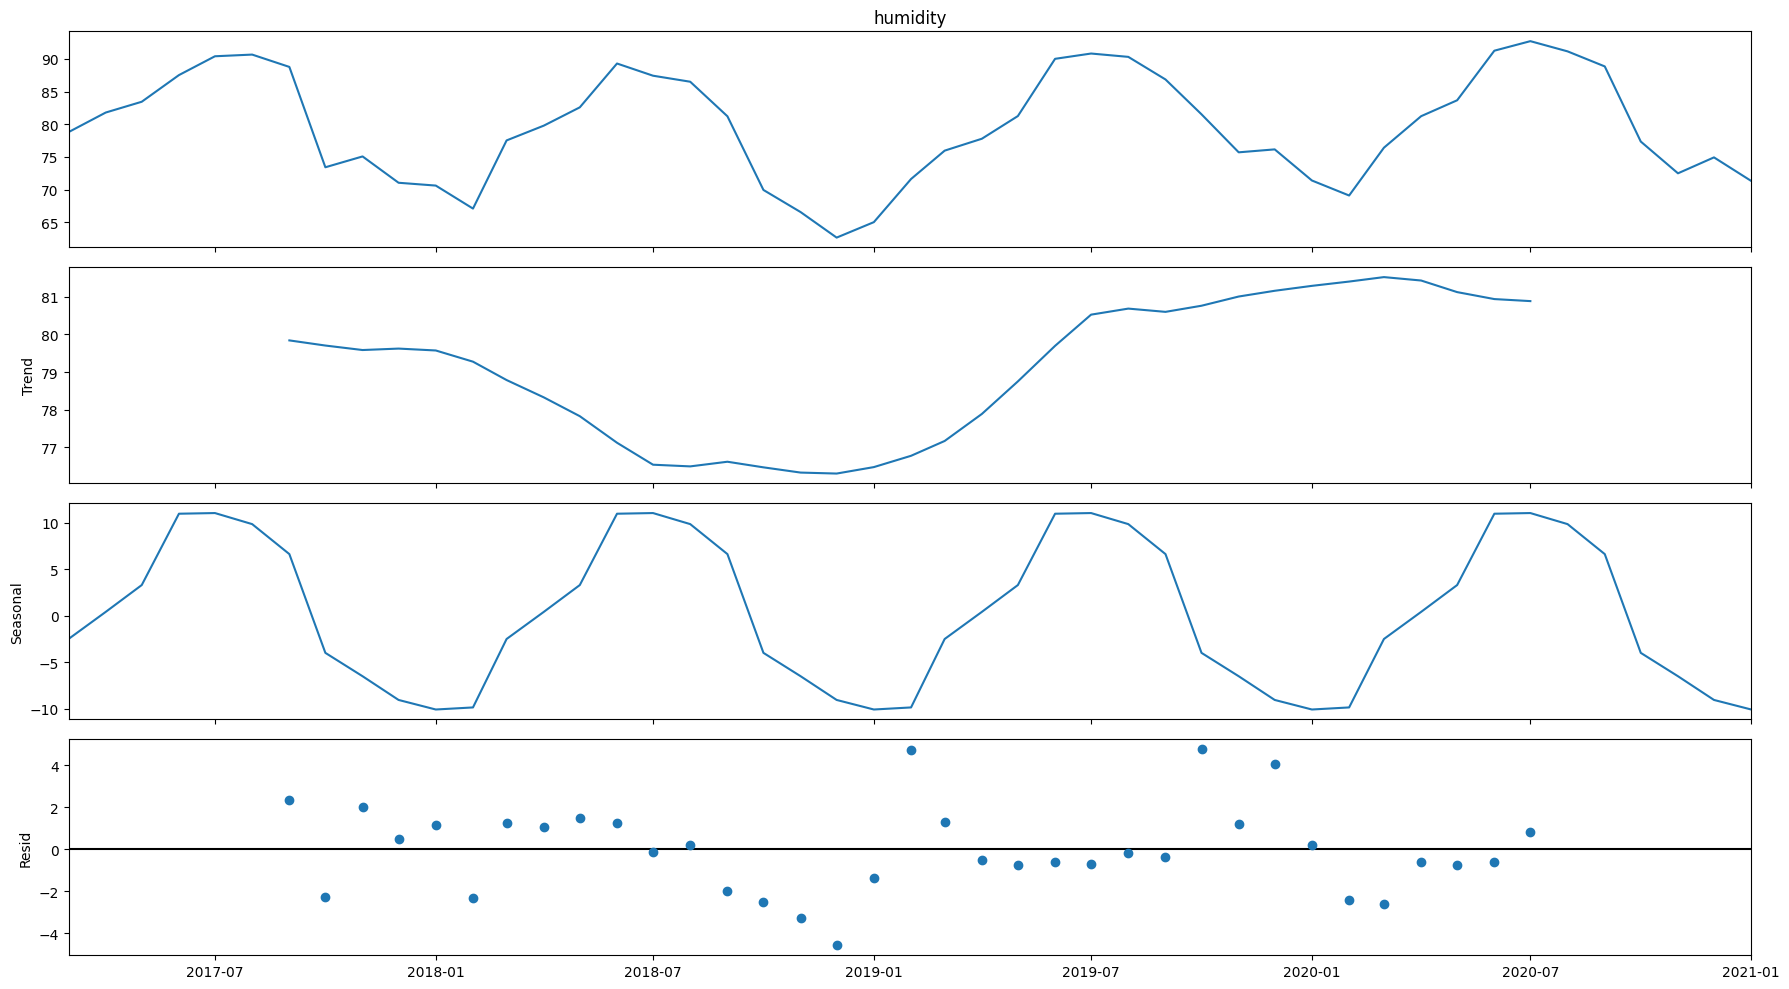

In [119]:
#decomposed time series
from pylab import rcParams
rcParams['figure.figsize'] = 18,10
decomposition_a = sm.tsa.seasonal_decompose(data_sar_month, model="additive")
fig=decomposition_a.plot()
plt.show()

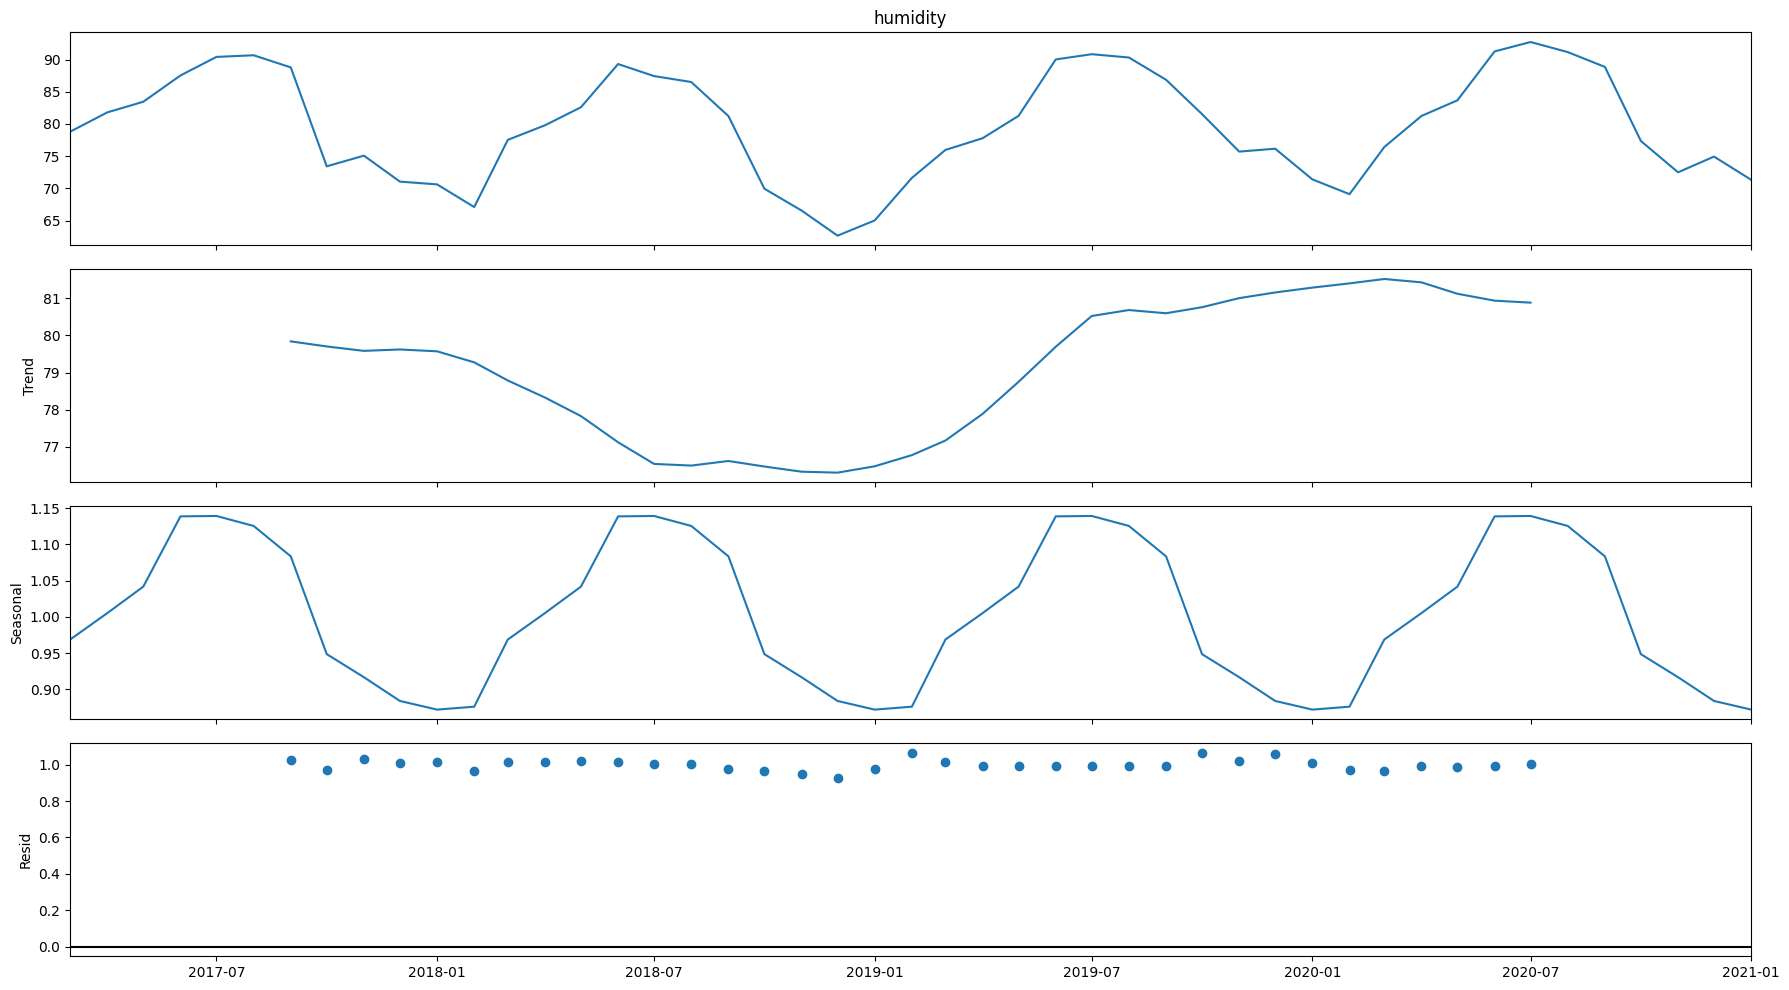

In [118]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,10
decomposition_m = sm.tsa.seasonal_decompose(data_sar_month, model="multiplicative")
fig=decomposition_m.plot()
plt.show()

##### Model

In [122]:
#perform grid search with a list of possible vals for params 
# and take the model with the least AIC
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [123]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)


In [124]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

### Multivariate LSTM

In [177]:
#!pip install tensorflow
#!pip install keras

In [178]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

##### designing network

In [190]:
test_x.shape

(10080, 9)

*using train_x, train_y, test_x, test_y from above

In [192]:
lstm_data = actuals[['hour_cos', 'hour_sin', 'month_cos', 'month_sin', 'cloud_cover', 
                'temperature_c', 'wind_direction', 'wind_speed_kmh', 'pressure_kpa',
                'humidity']]

In [197]:
#split into train and test sets
values = lstm_data.values

train_lstm = values[:int((len(values)+1)*.70)] 
test_lstm = values[int(len(values)*.70+1):] 

train_xl, train_yl = train_lstm[:, :-1], train_lstm[:, -1]
test_xl, test_yl = test_lstm[:, :-1], test_lstm[:, -1]

In [198]:
#reshaping input into 3D
train_x3d = train_xl.reshape((train_xl.shape[0], 1, train_xl.shape[1]))
test_x3d = test_xl.reshape((test_xl.shape[0], 1, test_xl.shape[1]))

In [205]:
print(train_x3d.shape, train_yl.shape, test_x3d.shape, test_yl.shape)

(23520, 1, 9) (23520,) (10079, 1, 9) (10079,)


In [213]:
# train and test defined above (train_x, train_y, text_x, test_y)
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(train_x3d.shape[1], train_x3d.shape[2])))
lstm.add(Dense(2))
lstm.compile(loss='mae', optimizer='adam')

In [214]:
#fitting the network
lstm_fit = lstm.fit(train_x3d, train_yl, epochs=30, batch_size=72, 
                    validation_data=(test_x3d, test_yl), verbose=2, 
                    shuffle=False)

Epoch 1/30
327/327 - 6s - loss: 77.2186 - val_loss: 75.2936 - 6s/epoch - 18ms/step
Epoch 2/30
327/327 - 1s - loss: 72.5955 - val_loss: 70.5401 - 1s/epoch - 4ms/step
Epoch 3/30
327/327 - 1s - loss: 67.8324 - val_loss: 65.8702 - 1s/epoch - 4ms/step
Epoch 4/30
327/327 - 1s - loss: 63.1965 - val_loss: 61.2571 - 1s/epoch - 4ms/step
Epoch 5/30
327/327 - 1s - loss: 58.5955 - val_loss: 56.6656 - 1s/epoch - 4ms/step
Epoch 6/30
327/327 - 1s - loss: 54.0100 - val_loss: 52.0852 - 1s/epoch - 4ms/step
Epoch 7/30
327/327 - 1s - loss: 49.4332 - val_loss: 47.5115 - 1s/epoch - 4ms/step
Epoch 8/30
327/327 - 1s - loss: 44.8697 - val_loss: 42.9506 - 1s/epoch - 4ms/step
Epoch 9/30
327/327 - 1s - loss: 40.3194 - val_loss: 38.3899 - 1s/epoch - 4ms/step
Epoch 10/30
327/327 - 1s - loss: 35.7719 - val_loss: 33.8356 - 1s/epoch - 4ms/step
Epoch 11/30
327/327 - 1s - loss: 31.2564 - val_loss: 29.3305 - 1s/epoch - 4ms/step
Epoch 12/30
327/327 - 1s - loss: 26.8455 - val_loss: 24.9716 - 1s/epoch - 4ms/step
Epoch 13/30


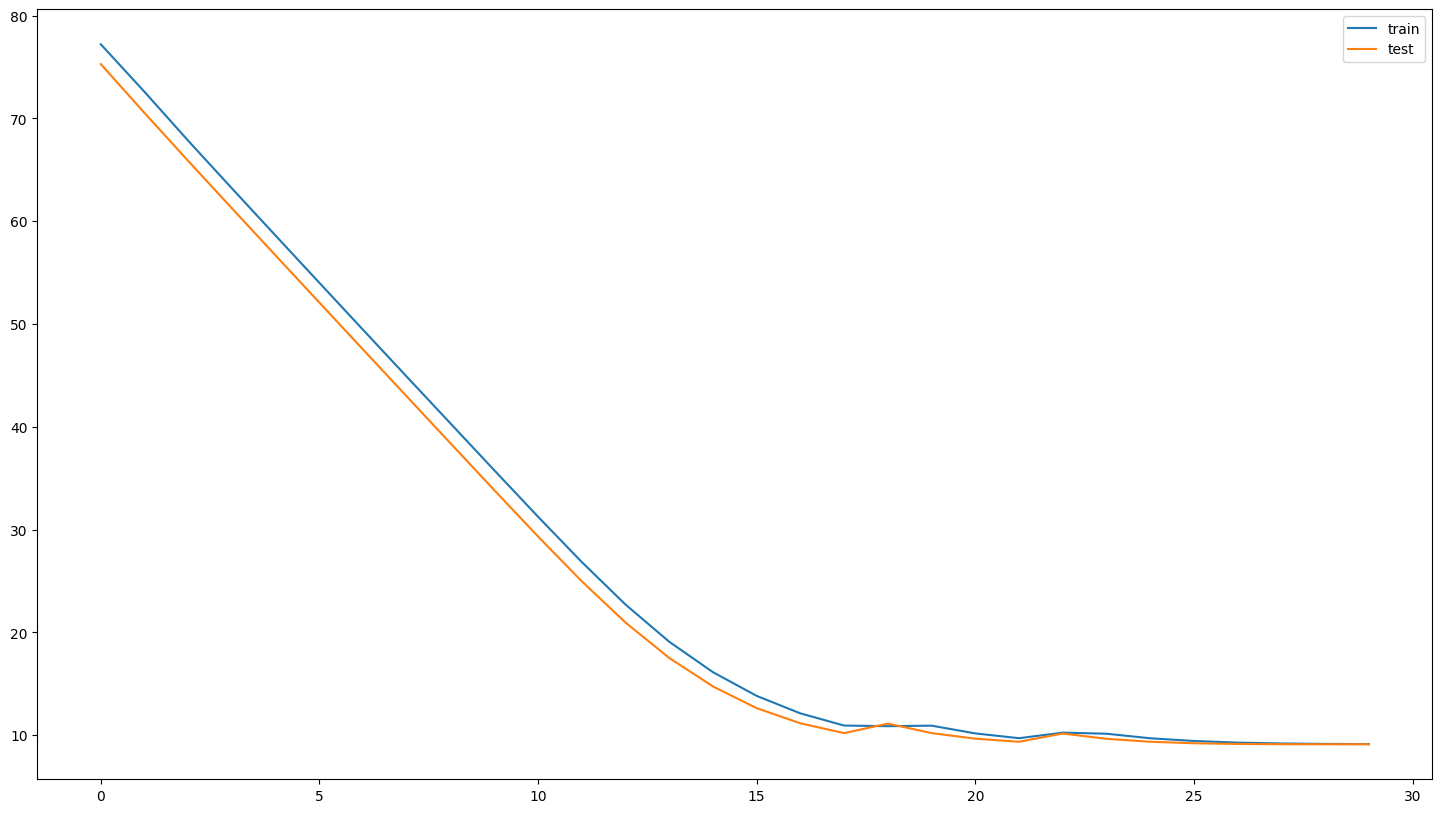

In [216]:
# plot history
plt.plot(lstm_fit.history['loss'], label='train')
plt.plot(lstm_fit.history['val_loss'], label='test')
plt.legend()
plt.show()

In [219]:
# make a prediction
yhat = lstm.predict(test_x3d)
test_x3d = test_x3d.reshape((test_x3d.shape[0], test_x3d.shape[2]))

315/315 [==============================] - 2s 3ms/step


In [224]:
test_x3d.shape

(10079, 9)

In [228]:
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler

In [230]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [231]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_x3d[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [223]:
test_y = test_yl.reshape((len(test_yl), 1))
inv_y = concatenate((test_yl, test_x3d[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

AxisError: axis 1 is out of bounds for array of dimension 1

In [220]:
mse = mean_squared_error(inv_y, inv_yhat)
print(' Test RMSE: %.3f' % mse)

NameError: name 'inv_y' is not defined